In [1]:
import json
import numpy as np
import drift_algorithms as algo
from tqdm import tqdm
import emip_toolkit as EMTK
import correction
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext autoreload
%autoreload 2

In [2]:
# file = open('synthetic_dataset_with_time.txt', 'r')
# text = file.read()
# data = json.loads(text)

# #the result is a Python dictionary:
# #print(data['robot1'][0])

In [13]:
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")

file_path = "./"

aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()

line_ys = correction.find_lines_Y(aoi)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

Load classifier models

In [14]:
model = tf.keras.models.load_model("saved_models/model_tl.h5")

Classification accuracy with incremental possibilities of errors

In [15]:
input_x = 520
input_y = 299

errors = [0,1,2,3]

In [16]:
noise_results = [[],[],[],[],[],[],[],[],[],[],[]]
shift_results = [[],[],[],[],[],[],[],[],[],[],[]]
droop_results = [[],[],[],[],[],[],[],[],[],[],[]]
offset_results = [[],[],[],[],[],[],[],[],[],[],[]]


noise_predicted = [[],[],[],[],[],[],[],[],[],[],[]]
shift_predicted = [[],[],[],[],[],[],[],[],[],[],[]]
droop_predicted = [[],[],[],[],[],[],[],[],[],[],[]]
offset_predicted = [[],[],[],[],[],[],[],[],[],[],[]]

results = {
    0: [noise_results, noise_predicted],
    1: [shift_results, shift_predicted],
    2: [droop_results, droop_predicted],
    3: [offset_results, offset_predicted]
    
}

for robot_index in tqdm(range(5)):
    for error_type in errors:
        for error_probability in range(0, 11):
            synth_fixations = correction.generate_fixations_lr_skip_regression(aois_with_tokens)
            
            error_test = correction.add_random_error(
                error_type, 
                synth_fixations,
                error_probability
                )

            predicted_error = correction.predict_error(
                image, 
                error_test, 
                aois_with_tokens, 
                input_x, 
                input_y, 
                model)
            
            # grab the proper list in the dictionary
            r = results[error_type]
            r[1][error_probability].append(predicted_error)

            # print(f"error: {error_type}, Predicted: {predicted_error}")

            if error_probability == 0: # no error 
                r[0][error_probability].append(correction.validate_prediction(predicted_error, 4))
            else:
                r[0][error_probability].append(correction.validate_prediction(predicted_error, error_type))

100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


### Error and probability test

In [9]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [17]:
mean_noise_results = mean_error_group(noise_results)
mean_shift_results = mean_error_group(shift_results)
mean_droop_results = mean_error_group(droop_results)
mean_offset_results = mean_error_group(offset_results)

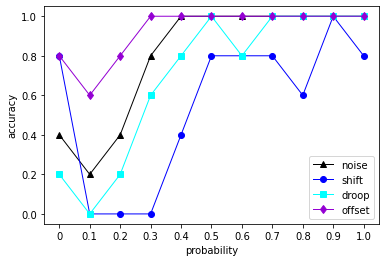

In [18]:
plt.plot(mean_noise_results, color='Black', linewidth=1, marker='^')
plt.plot(mean_shift_results, color='Blue', linewidth=1, marker='o')
plt.plot(mean_droop_results, color='Aqua', linewidth=1, marker='s')
plt.plot(mean_offset_results, color='DarkViolet', linewidth=1, marker='d')
# plt.plot(mean_no_error_results, color='red', linewidth=1, marker='^')

plt.legend(['noise', 'shift', 'droop', 'offset', "no error"])
plt.ylabel('accuracy')
plt.xlabel('probability')

x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
plt.show()

In [19]:
print(mean_noise_results, mean_droop_results, mean_shift_results, mean_offset_results)

[0.8666666666666667, 0.3, 0.4, 0.5666666666666667, 0.6333333333333333, 0.7333333333333333, 0.9333333333333333, 0.9333333333333333, 1, 1, 1] [0.8333333333333334, 0.43333333333333335, 0.9666666666666667, 1, 1, 1, 1, 1, 1, 1, 1] [0.7, 0.26666666666666666, 0.36666666666666664, 0.8666666666666667, 0.9, 0.9666666666666667, 0.9666666666666667, 1, 1, 1, 1] [0.7, 0.2, 0.4, 0.7333333333333333, 0.7, 0.8666666666666667, 0.9666666666666667, 0.9666666666666667, 1, 1, 0.9666666666666667]


In [19]:
print("mean noise:", statistics.mean(mean_noise_results))
print("mean droop:", statistics.mean(mean_droop_results))
print("mean shift:", statistics.mean(mean_shift_results))
print("mean offset:", statistics.mean(mean_offset_results))

mean noise: 0.8
mean droop: 0.6909090909090909
mean shift: 0.5454545454545455
mean offset: 0.9272727272727272


Offset prediction errors

In [20]:
stats = []
for prob in offset_predicted:
    summ = {}
    for pred in prob:
        if pred in summ:
            summ[pred] += 1
        else:
            summ[pred] = 1
    stats.append(summ)

In [21]:
visual = []

for i in range(len(stats)):
    keys = list(stats[i].keys())
    vals = list(stats[i].values())
    for j in range(len(keys)):
        visual.append([i, keys[j], vals[j]])
visual = np.array(visual)

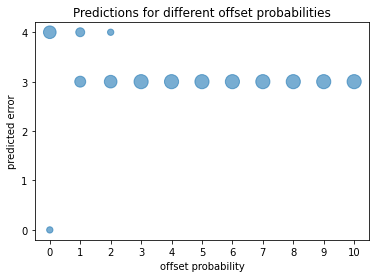

In [22]:
plt.scatter(visual[:,0], visual[:,1], s=visual[:,2]*40, alpha = 0.6)
plt.title("Predictions for different offset probabilities")
plt.xlabel("offset probability")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.ylabel("predicted error")
plt.yticks([e for e in range(0, 5)])
plt.show()

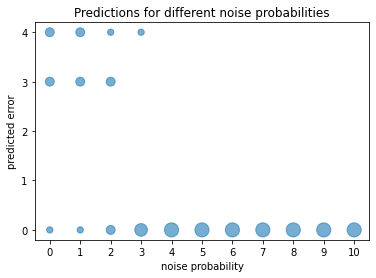

In [23]:
stats = []
for prob in noise_predicted:
    summ = {}
    for pred in prob:
        if pred in summ:
            summ[pred] += 1
        else:
            summ[pred] = 1
    stats.append(summ)

visual = []

for i in range(len(stats)):
    keys = list(stats[i].keys())
    vals = list(stats[i].values())
    for j in range(len(keys)):
        visual.append([i, keys[j], vals[j]])
visual = np.array(visual)

plt.scatter(visual[:,0], visual[:,1], s=visual[:,2]*40, alpha = 0.6)
plt.title("Predictions for different noise probabilities")
plt.xlabel("noise probability")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.ylabel("predicted error")
plt.yticks([e for e in range(0, 5)])
plt.show()

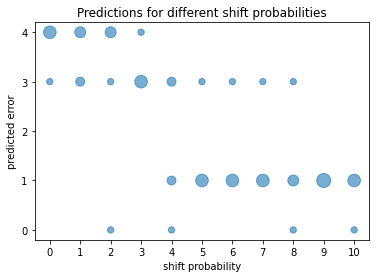

In [24]:
stats = []
for prob in shift_predicted:
    summ = {}
    for pred in prob:
        if pred in summ:
            summ[pred] += 1
        else:
            summ[pred] = 1
    stats.append(summ)

visual = []

for i in range(len(stats)):
    keys = list(stats[i].keys())
    vals = list(stats[i].values())
    for j in range(len(keys)):
        visual.append([i, keys[j], vals[j]])
visual = np.array(visual)

plt.scatter(visual[:,0], visual[:,1], s=visual[:,2]*40, alpha = 0.6)
plt.title("Predictions for different shift probabilities")
plt.xlabel("shift probability")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.ylabel("predicted error")
plt.yticks([e for e in range(0, 5)])
plt.show()

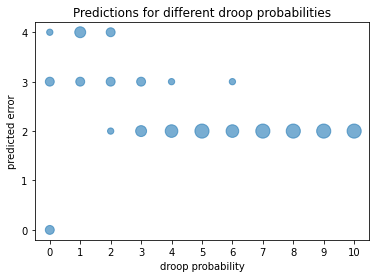

In [25]:
stats = []
for prob in droop_predicted:
    summ = {}
    for pred in prob:
        if pred in summ:
            summ[pred] += 1
        else:
            summ[pred] = 1
    stats.append(summ)

visual = []

for i in range(len(stats)):
    keys = list(stats[i].keys())
    vals = list(stats[i].values())
    for j in range(len(keys)):
        visual.append([i, keys[j], vals[j]])
visual = np.array(visual)

plt.scatter(visual[:,0], visual[:,1], s=visual[:,2]*40, alpha = 0.6)
plt.title("Predictions for different droop probabilities")
plt.xlabel("droop probability")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.ylabel("predicted error")
plt.yticks([e for e in range(0, 5)])
plt.show()